In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
df = pd.concat([pd.read_csv('training_set_features.csv').drop('respondent_id', axis=1),
                pd.read_csv('training_set_labels.csv').drop('respondent_id', axis=1)], axis=1)
new_data = pd.read_csv('test_set_features.csv')
Index = new_data['respondent_id']
new_data.drop('respondent_id', axis=1, inplace=True)

In [4]:
# Label encoding for categorical variables
le = LabelEncoder()
object_columns = df.columns[df.dtypes == 'object'].tolist()
for c in object_columns:
    df[c] = df[c].fillna('unknown')
    new_data[c] = new_data[c].fillna('unknown')
    df[c] = le.fit_transform(df[c])
    if c in new_data:
        new_data[c] = le.transform(new_data[c])
df.fillna(-1, inplace=True)
new_data.fillna(-1, inplace=True)

# Convert all columns to int (if required)
df = df.astype('int')
new_data = new_data.astype('int')

In [5]:
# Split the data into training and test sets
X = df.drop(['xyz_vaccine', 'seasonal_vaccine'], axis=1)
y = df[['xyz_vaccine', 'seasonal_vaccine']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
new_data_scaled = scaler.transform(new_data)

In [7]:
# Define the Logistic Regression model
log_reg = LogisticRegression(solver="liblinear")

# Use MultiOutputClassifier to handle multiple outputs
multi_target_model = MultiOutputClassifier(log_reg, n_jobs=-1)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100],
    'estimator__penalty': ['l1', 'l2']
}

In [8]:
# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(multi_target_model, param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred_proba = best_model.predict_proba(X_test_scaled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [9]:

# Calculate ROC AUC for each target variable
roc_auc_xyz_vaccine = roc_auc_score(y_test['xyz_vaccine'], y_pred_proba[0][:, 1])
roc_auc_seasonal_vaccine = roc_auc_score(y_test['seasonal_vaccine'], y_pred_proba[1][:, 1])
mean_roc_auc = np.mean([roc_auc_xyz_vaccine, roc_auc_seasonal_vaccine])

print(f'Best Parameters: {grid_search.best_params_}')
print(f'ROC AUC for xyz_vaccine: {roc_auc_xyz_vaccine}')
print(f'ROC AUC for seasonal_vaccine: {roc_auc_seasonal_vaccine}')
print(f'Mean ROC AUC: {mean_roc_auc}')

Best Parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l1'}
ROC AUC for xyz_vaccine: 0.8471654942893883
ROC AUC for seasonal_vaccine: 0.8349206537375027
Mean ROC AUC: 0.8410430740134455


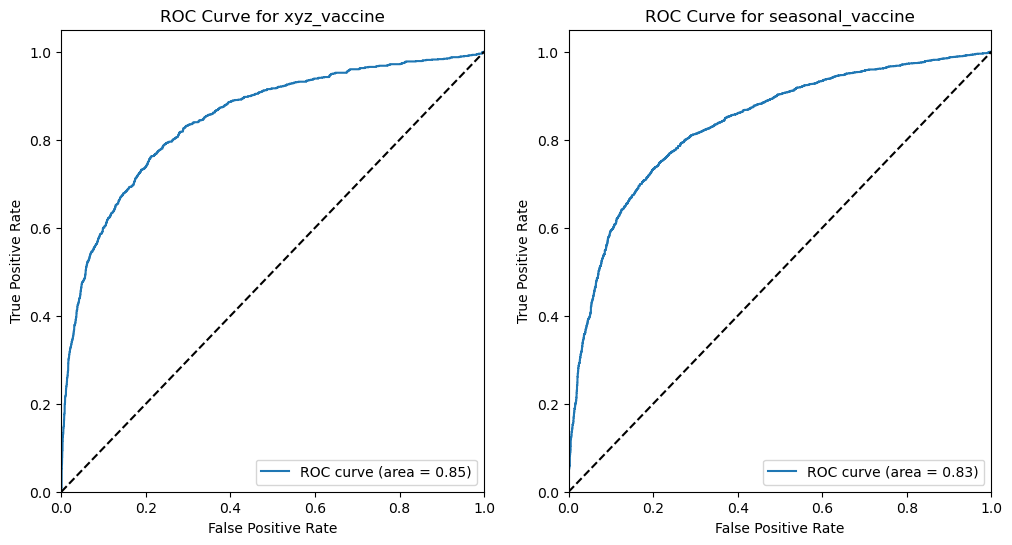

In [10]:
# Plot ROC Curve for each target variable
fpr_xyz, tpr_xyz, _ = roc_curve(y_test['xyz_vaccine'], y_pred_proba[0][:, 1])
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_test['seasonal_vaccine'], y_pred_proba[1][:, 1])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr_xyz, tpr_xyz, label='ROC curve (area = %0.2f)' % roc_auc_xyz_vaccine)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for xyz_vaccine')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr_seasonal, tpr_seasonal, label='ROC curve (area = %0.2f)' % roc_auc_seasonal_vaccine)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for seasonal_vaccine')
plt.legend(loc="lower right")
plt.show()

In [11]:
pred=best_model.predict_proba(new_data_scaled)

In [12]:
output=pd.DataFrame.from_dict({
    'respondent_id':Index,
    'h1n1_vaccine':pred[0][:, 1],
    'seasonal_vaccine':pred[1][:, 1]
})  

In [13]:
output

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.202466,0.390047
1,26708,0.051106,0.093818
2,26709,0.265742,0.650444
3,26710,0.456870,0.829235
4,26711,0.265707,0.463646
...,...,...,...
26703,53410,0.346527,0.613082
26704,53411,0.090830,0.294804
26705,53412,0.276493,0.314963
26706,53413,0.041084,0.438517


In [14]:
output.to_csv('submissionLogistic.csv',index=False)